In [1]:
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
from keras import backend as K
from keras.utils import to_categorical
import glob
import os
import segmentation_models_3D as sm
import nibabel as nib
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from scipy.ndimage import zoom
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

2023-06-11 05:10:33.928144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 05:10:34.062587: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


Segmentation Models: using `tf.keras` framework.


In [2]:
image_dir = '/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)'
mask_dir = '/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)'

#'/home/dnn4/pythonCodeArea/soham/New Folder
# image_path_t = glob.glob(r'/home/dnn4/pythonCodeArea/soham/New Folder/resized imgs(256)org/*.nii')
# mask_path_t = glob.glob(r'/home/dnn4/pythonCodeArea/soham/New Folder/resized masks(256)org/*.nii')

image_path_t = glob.glob(image_dir + '/*.nii.gz')
mask_path_t = glob.glob(mask_dir + '/*.nii.gz')

# image_path_t = glob.glob(os.path.join(image_dir, '*.nii'))
# mask_path_t = glob.glob(os.path.join(mask_dir, '*.nii'))

In [3]:
print("Number of image files:", len(image_path_t))
print("Number of mask files:", len(mask_path_t))

# Print the first few file paths for verification
print("Sample image file paths:")
for i in range(min(5, len(image_path_t))):
    print(image_path_t[i])

print("Sample mask file paths:")
for i in range(min(5, len(mask_path_t))):
    print(mask_path_t[i])

Number of image files: 38
Number of mask files: 38
Sample image file paths:
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K4-img.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K2-img.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K15-img.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K5-img.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/D17-img.nii.gz
Sample mask file paths:
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/D16-seg.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/D14-seg.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/K9-seg.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/K1-seg.nii.gz
/home/dnn4/pythonCodeArea/soham/New_folder/resized masks(256)/K20-seg.nii.gz


In [4]:
img_arr=[]
mask_arr=[]
for x in image_path_t:
  im=nib.load(x)
  img=np.array(im.dataobj)
  img_arr.append(img)
for y in mask_path_t:
  ma=nib.load(y)
  mask=np.array(ma.dataobj)
  mask_arr.append(mask)

In [5]:
input_img=np.array(img_arr)
input_mask=np.array(mask_arr)
input_img=np.stack((input_img,)*3,axis=-1)
input_mask=np.expand_dims(input_mask,axis=-1)
input_img=input_img.astype(np.float32)
input_mask=input_mask.astype(np.float32)
print(input_img.shape)
print(input_mask.shape)

(38, 256, 256, 64, 3)
(38, 256, 256, 64, 1)


In [6]:
x_train, x_test, y_train, y_test= train_test_split(input_img,input_mask,test_size=0.2)
print(x_train.shape,y_test.shape)

(30, 256, 256, 64, 3) (8, 256, 256, 64, 1)


In [7]:
encoder_weights = 'imagenet'
BACKBONE = 'resnet34'  
LR = 0.01
optim = tf.keras.optimizers.SGD(LR)
metrics = [sm.metrics.IOUScore(), sm.metrics.FScore(),'binary_accuracy','Precision','Recall','AUC']

2023-06-11 05:10:41.580547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 05:10:41.607647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 05:10:41.607849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE,input_shape=(256,256,64,3),
                encoder_weights='imagenet',activation='sigmoid')
model.compile(optimizer = optim, loss=sm.losses.dice_loss, metrics=metrics)

In [9]:
lrp=ReduceLROnPlateau(monitor="val_loss",  patience=2)
#es=EarlyStopping(patience=2,monitor='iou_score')
call=[lrp]
history=model.fit(x_train,y_train,
         batch_size=1,
         epochs=30,
         validation_data=(x_test,y_test),
         callbacks=call)

Epoch 1/30


2023-06-11 05:10:49.814613: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:405] Cancel Transpose nodes around Pad: transpose_before=model_1/bn_data/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=model_1/zero_padding3d/Pad transpose_after=model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/model_1/conv0/Conv3D/Conv3DBackpropFilterV2-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/model_1/conv0/Conv3D/ShapeN-0-TransposeNDHWCToNCDHW-LayoutOptimizer
2023-06-11 05:10:53.078231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-06-11 05:10:58.665496: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1c674d1d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-11 05:10:58.665529: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-06-11 05:10:58.

30/30 [==============================] - ETA: 0s - loss: 0.9917 - iou_score: 0.0042 - f1-score: 0.0083 - binary_accuracy: 0.5485 - precision: 0.0051 - recall: 0.6582 - auc: 0.6507

2023-06-11 05:11:16.895177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


30/30 [==============================] - 36s 440ms/step - loss: 0.9917 - iou_score: 0.0042 - f1-score: 0.0083 - binary_accuracy: 0.5485 - precision: 0.0051 - recall: 0.6582 - auc: 0.6507 - val_loss: 0.9935 - val_iou_score: 0.0033 - val_f1-score: 0.0065 - val_binary_accuracy: 0.4048 - val_precision: 0.0041 - val_recall: 0.8914 - val_auc: 0.7602 - lr: 0.0100
Epoch 2/30
30/30 [==============================] - 8s 266ms/step - loss: 0.9897 - iou_score: 0.0052 - f1-score: 0.0103 - binary_accuracy: 0.5677 - precision: 0.0068 - recall: 0.8476 - auc: 0.8199 - val_loss: 0.9932 - val_iou_score: 0.0034 - val_f1-score: 0.0068 - val_binary_accuracy: 0.3403 - val_precision: 0.0039 - val_recall: 0.9425 - val_auc: 0.7902 - lr: 0.0100
Epoch 3/30
30/30 [==============================] - 8s 267ms/step - loss: 0.9877 - iou_score: 0.0062 - f1-score: 0.0123 - binary_accuracy: 0.6087 - precision: 0.0083 - recall: 0.9387 - auc: 0.9190 - val_loss: 0.9928 - val_iou_score: 0.0036 - val_f1-score: 0.0072 - val_bin

In [10]:
#model.evaluate(x_test,y_test)
#score= model.evaluate(x_train,y_train,verbose=0)
results = model.evaluate(x_test, y_test, verbose=0)

# Retrieve and print all metrics
metrics_names = model.metrics_names
for metric_name, metric_value in zip(metrics_names, results):
    print(f"{metric_name}: {metric_value}")

2023-06-11 05:15:26.429501: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-11 05:15:26.429571: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-11 05:15:26.429587: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-11 05:15:26.429600: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

loss: 0.9919980764389038
iou_score: 0.004017036873847246
f1-score: 0.008001929149031639
binary_accuracy: 0.9208011031150818
precision: 0.00750646973028779
recall: 0.2105938047170639
auc: 0.6131572723388672


In [11]:
test_img = x_train[0]
ground_truth=y_train[0]
test_img_input=np.expand_dims(test_img, 0)
test_pred1 = model.predict(test_img_input)
test_prediction1=(test_pred1>=0.5)
test_prediction1=np.squeeze(test_prediction1,axis=-1)
test_prediction1=np.squeeze(test_prediction1,axis=0)
print(test_prediction1.shape)

1/1 [==============================] - 1s 534ms/step
(256, 256, 64)


In [12]:
ground_truth_argmax = ground_truth>=0.5
ground_truth_argmax = np.squeeze(ground_truth_argmax, axis = -1)
print(ground_truth_argmax.shape)
print(test_img.shape)

(256, 256, 64)
(256, 256, 64, 3)


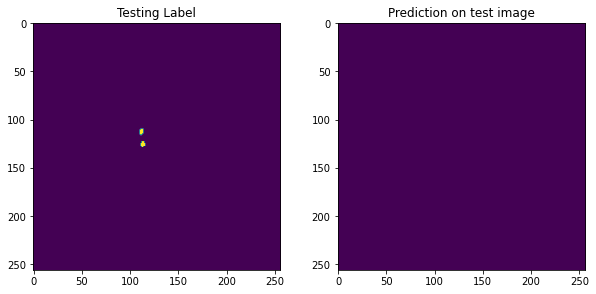

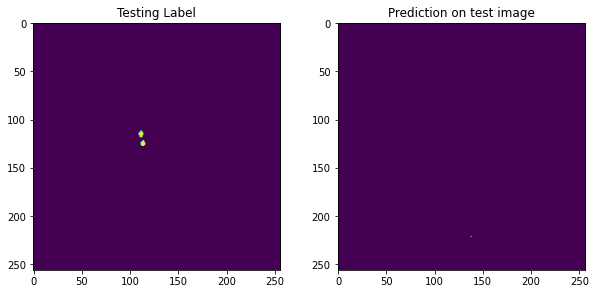

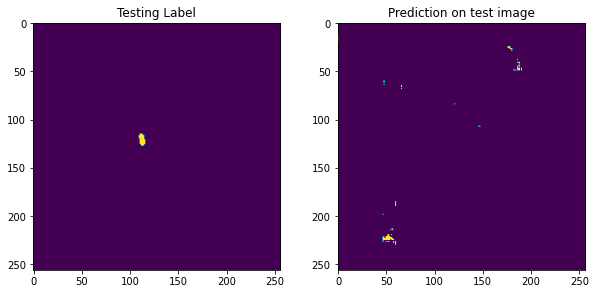

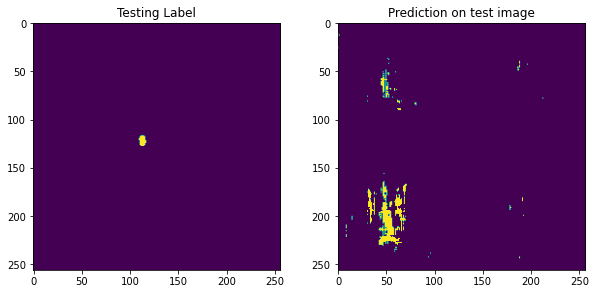

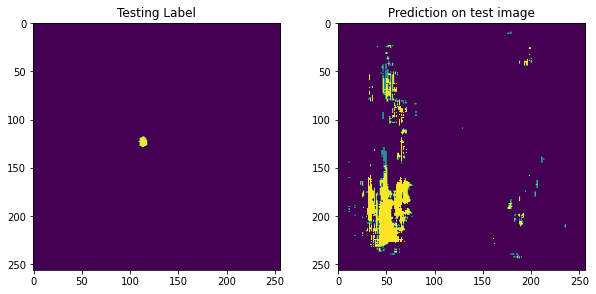

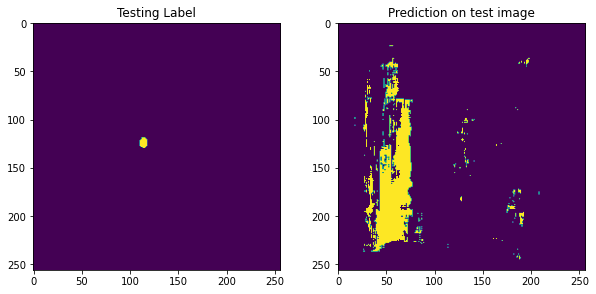

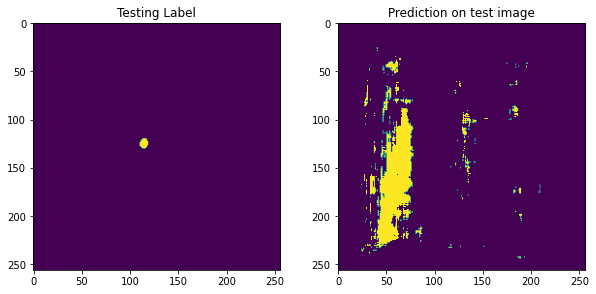

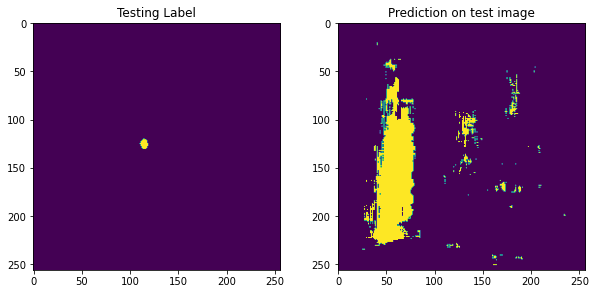

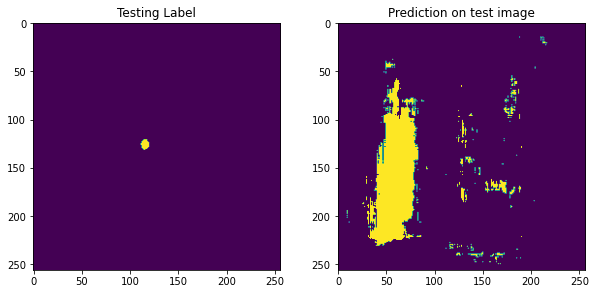

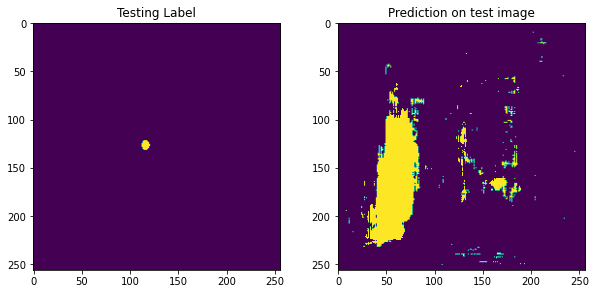

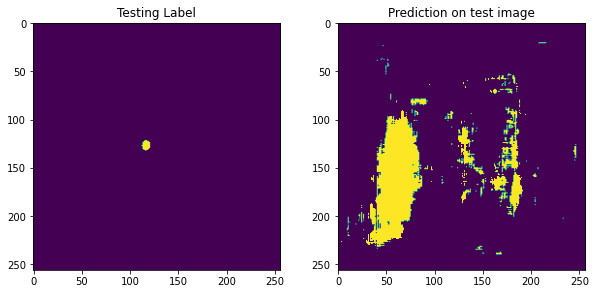

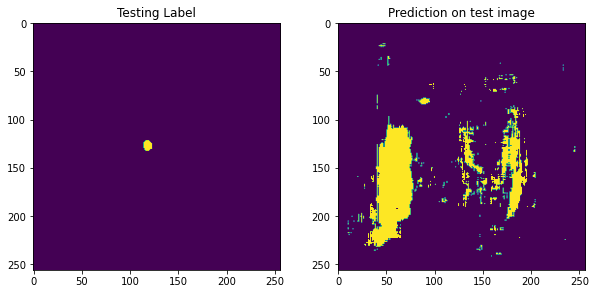

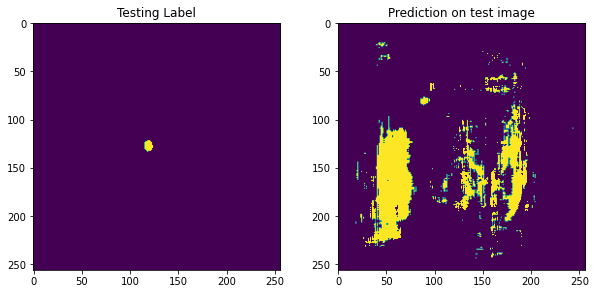

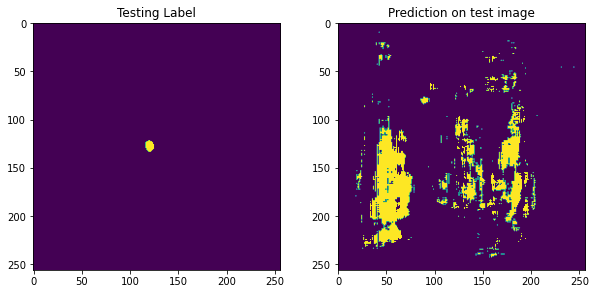

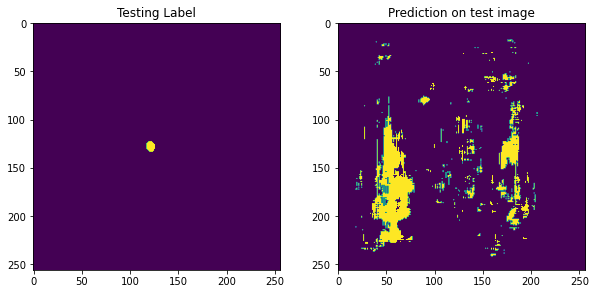

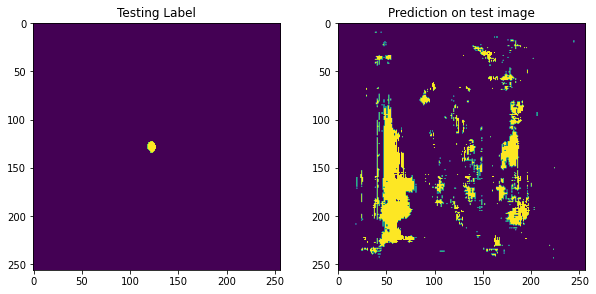

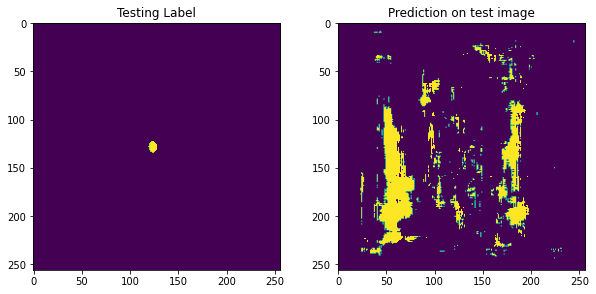

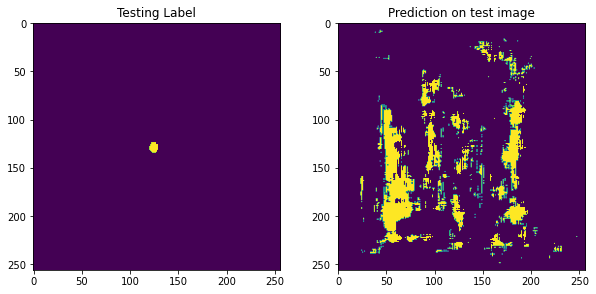

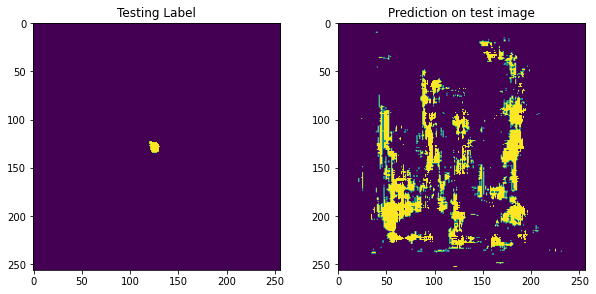

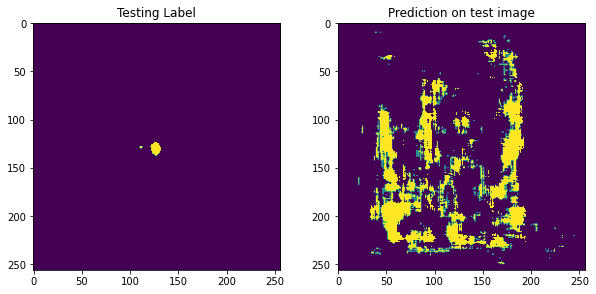

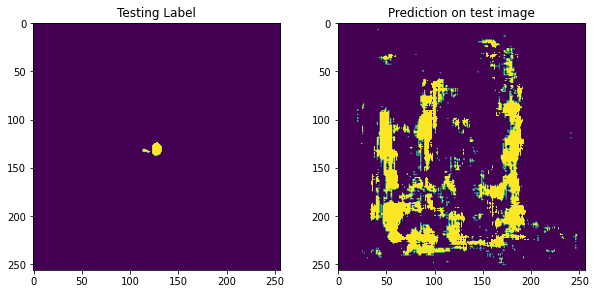

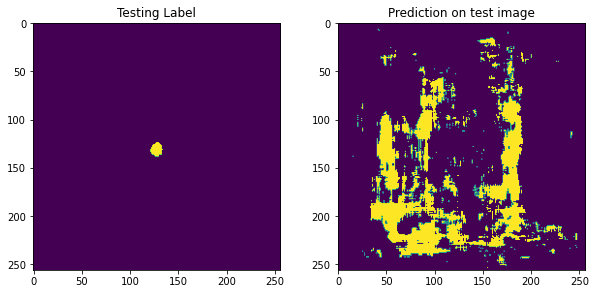

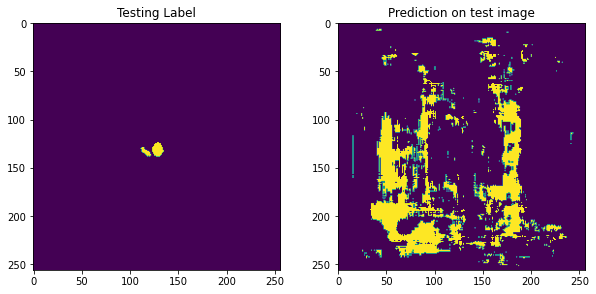

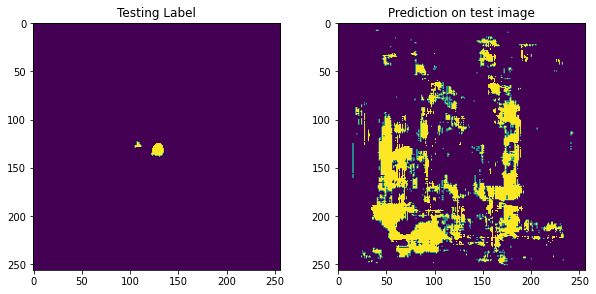

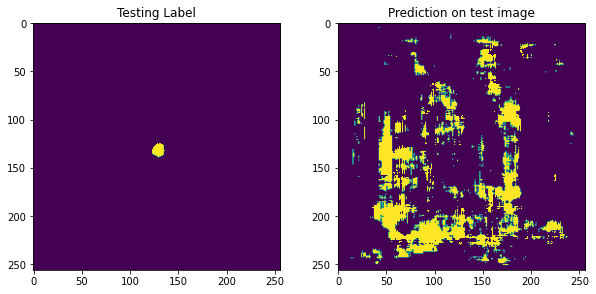

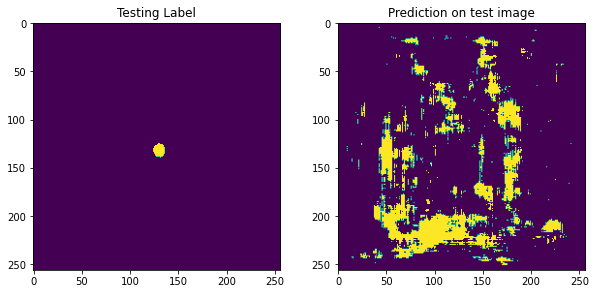

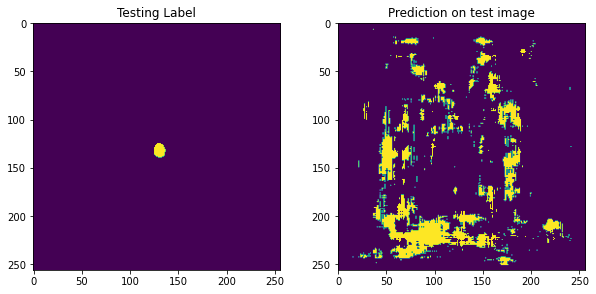

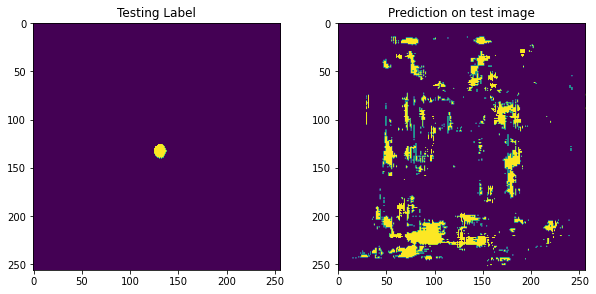

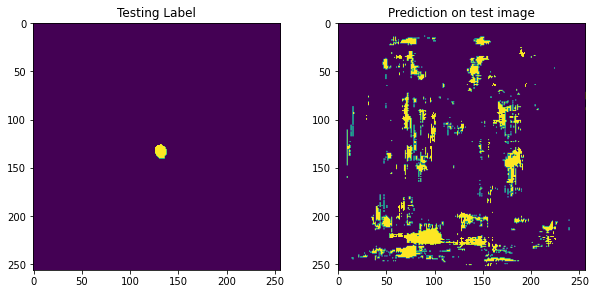

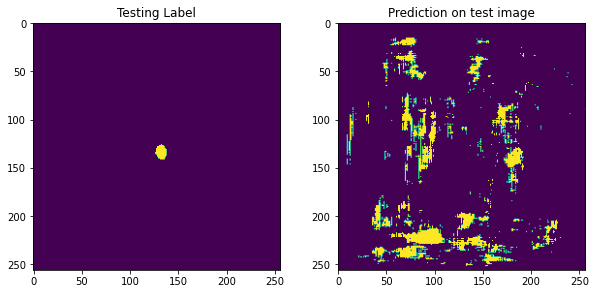

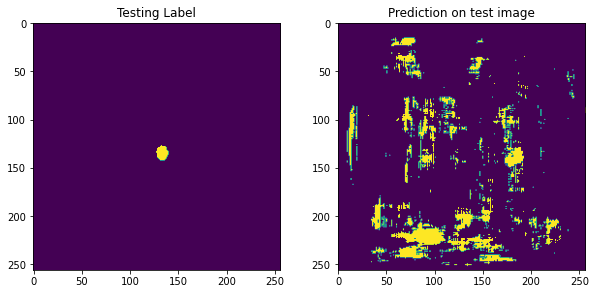

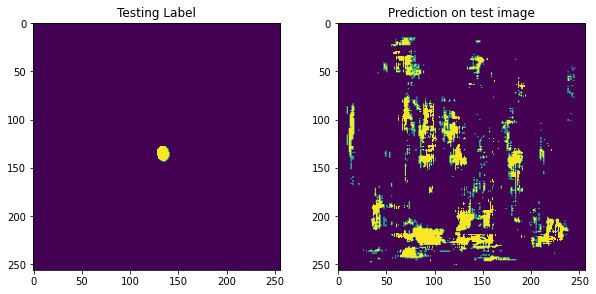

In [13]:
for x in range(32):
  plt.figure(figsize=(10,10)) 
  plt.subplot(221)
  plt.title('Testing Label')
  plt.imshow(ground_truth_argmax[:,:,x])
  plt.subplot(222)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction1[:,:,x])
  plt.show()

In [14]:
test_img=nib.load(r"/home/dnn4/pythonCodeArea/soham/New_folder/resized imgs(256)/K1-img.nii.gz")
test_im=np.array(test_img.dataobj)
test_img_input=np.stack((test_im,)*3, -1)
test_img_input=np.expand_dims(test_img_input,0)
print(test_img_input.shape)
test_pred1 = model.predict(test_img_input)
test_pred1=(test_pred1>=0.5)
#test_prediction1 = np.argmax(test_pred1, axis=4)
print(test_prediction1.shape)
print(np.unique(test_pred1))

(1, 256, 256, 64, 3)
1/1 [==============================] - 1s 867ms/step
(256, 256, 64)
[False  True]


In [15]:
reconstructed_image=np.reshape(test_pred1,(256,256,64))
reconstructed_image=reconstructed_image.astype(np.uint8)

In [16]:
print(test_img.affine)

[[   2.          0.          0.       -127.      ]
 [   0.          2.          0.       -127.      ]
 [   0.          0.         16.546875 -481.953125]
 [   0.          0.          0.          1.      ]]


In [17]:
out_img=nib.Nifti1Image(reconstructed_image,test_img.affine)
nib.save(out_img,'segmentation-output-k1-Unet(resnet34)')